#1. Introduction

It has been demontrate that languages spoken in the warmer climates are more likely to colexify the senses ICE and SNOW than the languages spoken in colder climates (Regier et al, 2016).

In a similar way, does distance to coasts affect the colexification of SEA and OCEAN in the languages of the world? It is interesting to study how the geographical context and the need for efficient communication shape the languages accross the world.

We make the assumption that in coastal regions, people are more likely to distinguish the senses of SEA and OCEAN.







#2. Data

###2.1 Librairies import

In [1]:
!pip install basemap

In [2]:
import numpy as np # linear algebra
import pandas as pd # data-frame manipulation
import matplotlib.pyplot as plt # plotting
import seaborn as sns # plotting
from mpl_toolkits.basemap import Basemap # map plotting
from scipy import stats # statistical tests
import geopandas as gpd # Geospatial data handling with pandas-like structures
from shapely.geometry import Point # Representation of points in geometric space
from geopy.distance import geodesic # Geodesic distance calculation
from shapely.ops import nearest_points # Finds closest points between two geometries

###2.2 Data import and manipulation

We use the Lexibank database, and especially data about the meaning and the form of words stored in the colums "Form" and "Concepticon_Gloss". It contains also important information to idenfiate the languages, such as their location and their glottocode.

In [3]:
lexibank = pd.read_csv('https://raw.githubusercontent.com/ClotCarrotte/2024-Projet-final-CARROTTE-CLOTILDE/refs/heads/main/lexibank_clipped.csv',
                           low_memory=False, index_col=0)
lexibank.head(5)


,Language_ID,Form,Latitude,Longitude,Glottocode,Concepticon_Gloss,Family
0,aaleykusunda-KusundaK,ɐ̃ː.ʤi,28.000000,82.260000,kusu1250,ABOVE,NaN
1,abrahammonpa-MonpaKalaktang,thuŋga,27.104162,92.113017,kala1376,ABOVE,Sino-Tibetan
2,abrahammonpa-MonpaDirang,thuŋga,27.349590,92.279140,tsha1245,ABOVE,Sino-Tibetan
3,abrahammonpa-MonpaChangprong,jur,27.578928,91.876393,dakp1242,ABOVE,Sino-Tibetan
4,abrahammonpa-SartangDarbuB,khuŋlo,27.329171,92.358727,sart1249,ABOVE,Sino-Tibetan


In [4]:
# Keep only rows that contains senses "SEA" and "OCEAN"
filtered_lexibank = lexibank.query(f'Concepticon_Gloss in {["SEA", "OCEAN"]}')

lang_colex = [] # initialisation of a list that will store the number of terms related to "SEA" and "OCEAN" concepts for each language.

for glottocode in filtered_lexibank.Glottocode.unique():
    language_subset = filtered_lexibank.query(f'Glottocode == "{glottocode}"') # Creation of subset dataframes for each language

    if language_subset.Concepticon_Gloss.nunique() >= 2: # Checking if the language possesses the two concepts "SEA" and "OCEAN"
        lang_colex.append([glottocode, len(language_subset.Form.unique())]) # adding the number of terms for each language in the list previously initialized

# Conversion into a dataframe
df_colex = pd.DataFrame(lang_colex)
df_colex.columns = ['glottocode', 'Number_of_terms']
df_colex['Number_of_terms'] = df_colex['Number_of_terms'].astype(int)

display(df_colex)

,glottocode,Number_of_terms
0,hawa1245,2
1,taki1248,2
2,plat1254,2
3,imba1240,1
4,chew1245,1
5,dutc1256,2
6,stan1293,2
7,viet1252,2
8,bezh1248,2
9,nucl1643,3


Now we extract geographical data from the glottolog database to get the latitude and the longitude for each language.

In [5]:
glottolog = pd.read_csv('https://raw.githubusercontent.com/ClotCarrotte/2024-Projet-final-CARROTTE-CLOTILDE/refs/heads/main/glottolog.csv')

# Merging the previous dataset (df_colex) and the glottolog using the glottocode
df_merged = pd.merge(df_colex, glottolog, on='glottocode', how='left')

# Drop useless columns for our analysis
df_merged = df_merged[['glottocode', 'name','Number_of_terms', 'latitude', 'longitude']]
df_merged.dropna(subset=['latitude', 'longitude'],inplace=True)


In [6]:
# Converting the latitude and longitude coordinates of each language into Point object.
geometry = [Point(lon, lat) for lon, lat in zip(df_merged['longitude'], df_merged['latitude'])]

# Creating a GeoDataFrame
gdf_languages = gpd.GeoDataFrame(df_merged, geometry=geometry)

# Setting the Coordinate Reference System (CRS) of the GeoDataFrame to WGS84 (EPSG:4326), which is standard for latitude/longitude
gdf_languages = gdf_languages.set_crs("EPSG:4326", inplace=True)


We have latitudes and longitudes for each language in our subset, so we can get distances to their nearest coast. We use coastlines data collected on [Natural Earth](https://www.naturalearthdata.com/) to compute them.

,scalerank,featurecla,min_zoom,geometry
0,0,Coastline,1.5,"LINESTRING (180 -16.15293, 179.84814 -16.21426..."
1,0,Coastline,4.0,"LINESTRING (177.25752 -17.0542, 177.2874 -17.0..."
2,0,Coastline,4.0,"LINESTRING (127.37266 0.79131, 127.35381 0.847..."
3,0,Coastline,3.0,"LINESTRING (-81.32231 24.68506, -81.42007 24.7..."
4,0,Coastline,4.0,"LINESTRING (-80.79941 24.84629, -80.83887 24.8..."
...,...,...,...,...
1423,0,Coastline,4.0,"LINESTRING (-81.78384 24.54458, -81.73975 24.5..."
1424,0,Coastline,4.0,"LINESTRING (-86.7269 21.26431, -86.73906 21.27..."
1425,0,Coastline,4.0,"LINESTRING (-165.82222 66.32808, -166.03252 66..."
1426,0,Coastline,4.0,"LINESTRING (54.42656 24.47104, 54.39834 24.506..."


<Axes: >

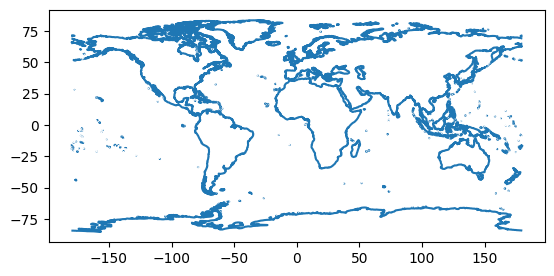

In [7]:
# Converting the file containing coastline data into a GeoDataFrame
gdf_coasts = gpd.read_file('ne_50m_coastline.shp')

# Setting the Coordinate Reference System (CRS) of the GeoDataFrame to WGS84 (EPSG:4326), which is standard for latitude/longitude
gdf_coasts.set_crs("EPSG:4326", inplace=True)

# Visualisation of the data
display(gdf_coasts)
gdf_coasts.plot()

In [8]:
# Calculation of the distances between languages and the nearest coasts

def calculate_distance_to_coast(language_point, coast_geometry): # Function to calculate the distance from a language point to the nearest coastline.
    nearest_point = nearest_points(language_point, coast_geometry)[1] # Find the nearest point on the coastline to the given language point

    lang_coords = (language_point.y, language_point.x) # Extract the latitude and longitude of language point
    coast_coords = (nearest_point.y, nearest_point.x) # Extract the latitude and longitude of the nearest coastline point

    distance_km = geodesic(lang_coords, coast_coords).km # Calculate the euclidean distance (in kilometers) using geopy
    return distance_km

# Application of the function to each language :
gdf_languages['distance_to_coast_km'] = gdf_languages['geometry'].apply(
    lambda language_point: min([calculate_distance_to_coast(language_point, coast) for coast in gdf_coasts['geometry']]))

gdf_languages.head(5)


,glottocode,name,Number_of_terms,latitude,longitude,geometry,distance_to_coast_km
0,hawa1245,Hawaiian,2,19.62970,-155.4300,POINT (-155.43 19.6297),40.365164
1,taki1248,Takia,2,-4.69057,145.9750,POINT (145.975 -4.69057),5.585151
2,plat1254,Plateau Malagasy,2,-19.59070,47.1211,POINT (47.1211 -19.5907),179.376272
3,imba1240,Imbabura Highland Quichua,1,0.31776,-78.3729,POINT (-78.3729 0.31776),114.410422
4,chew1245,Chewong,1,3.83331,102.0810,POINT (102.081 3.83331),107.915285


###2.3 Data description

<ipython-input-15-96292b62dca9>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis", legend = False)
<ipython-input-15-96292b62dca9>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gdf_languages['distance_to_coast_km'], y=gdf_languages['name'], palette="viridis")


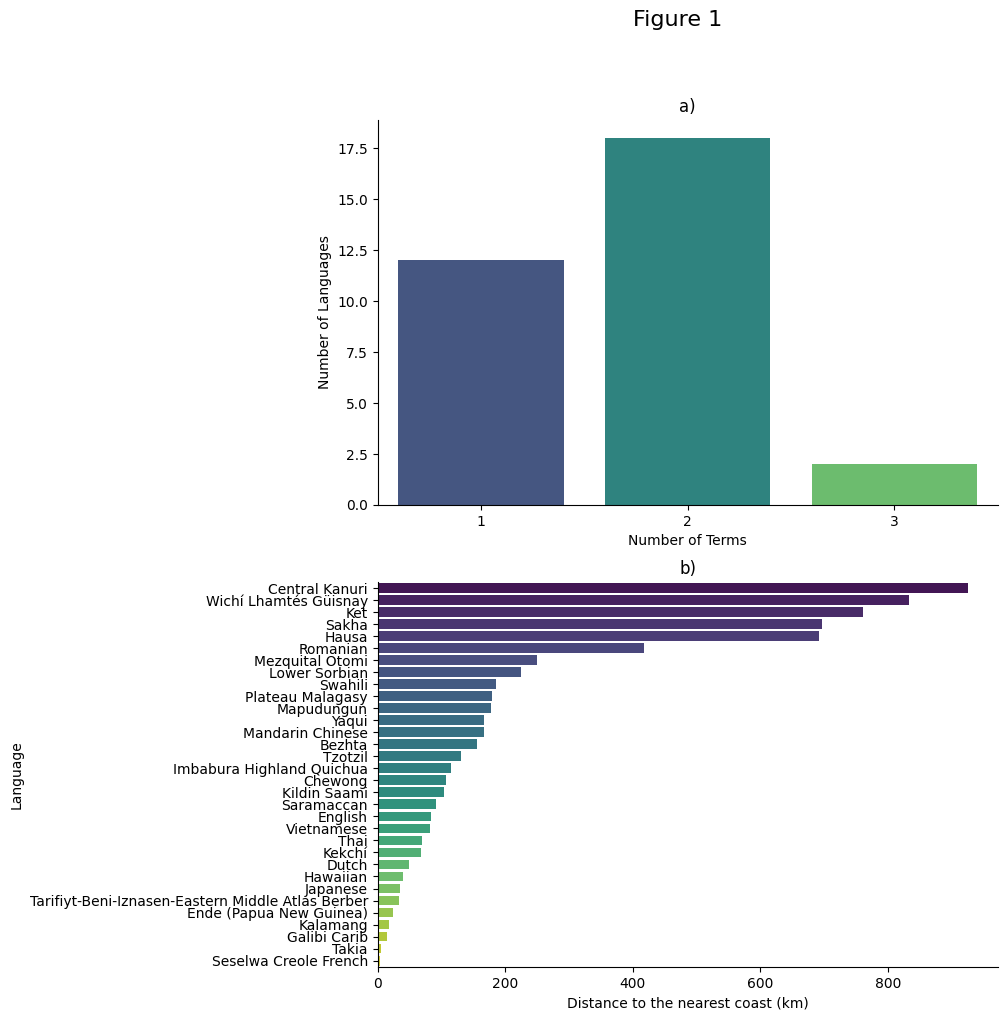

In [15]:
# Construction of a panel
fig1 = plt.figure(figsize=(8, 11)) # Setting the size of the panel
fig1.suptitle("Figure 1", fontsize=16)

# Figure 1.a : Distribution of the number of terms for SEA and OCEAN
plt.subplot(2, 1, 1)
counts = gdf_languages['Number_of_terms'].value_counts().sort_index()
sns.barplot(x=counts.index, y=counts.values, palette="viridis", legend = False)
plt.xlabel("Number of Terms") # Labelling the axes
plt.ylabel("Number of Languages")
plt.title("a)")
sns.despine()

# Figure 1.b : Distribution of the distance to the nearest coast for each language
plt.subplot(2, 1, 2)
gdf_languages = gdf_languages.sort_values(by='distance_to_coast_km', ascending=False) # Sorting the dataset for better visualisation
sns.barplot(x=gdf_languages['distance_to_coast_km'], y=gdf_languages['name'], palette="viridis")
plt.xlabel("Distance to the nearest coast (km)") # Labelling the axes
plt.ylabel("Language")
plt.title("b)")
sns.despine()

plt.show()

#3. Analysis

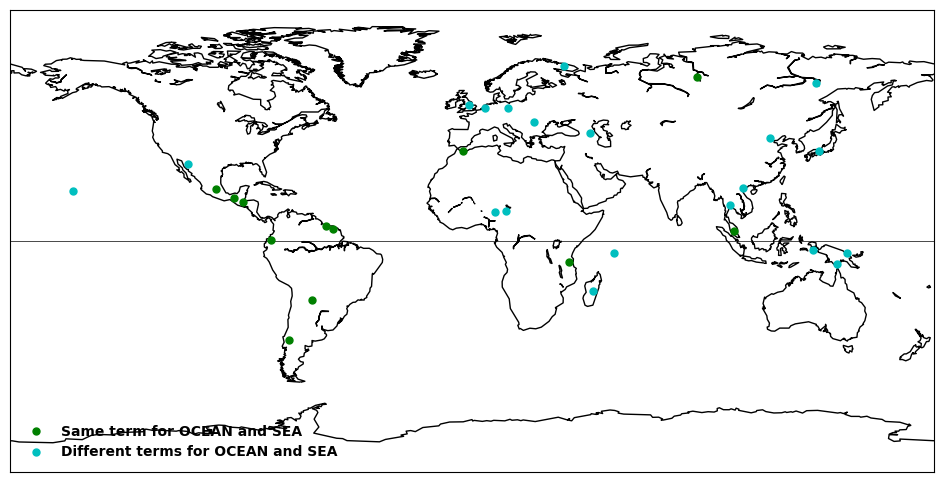

In [10]:
# Adding a column to make representations easier for same or different terms for I and SNOW:
gdf_languages['Number_of_terms_bin'] = np.where(gdf_languages['Number_of_terms'] == 1,
                                                'same', np.where(gdf_languages['Number_of_terms'] >= 2,
                                                'different', 'different')) # Transform the number of terms into a binary variable "same" and "different"

# Plotting a map :
x_same = gdf_languages.query('Number_of_terms_bin == "same"')['longitude'] # Extract longitude values for languages using the same term
y_same = gdf_languages.query('Number_of_terms_bin == "same"')['latitude']# Extract latitude values for languages using the same term

x_different = gdf_languages.query('Number_of_terms_bin == "different"')['longitude'] # Extract longitude values for languages using different terms
y_different = gdf_languages.query('Number_of_terms_bin == "different"')['latitude'] # Extract latitude values for languages using different terms

plt.figure(figsize=(12, 6)) # Setting the size of the plot

# Create a Basemap instance with a cylindrical projection centered at the equator with a low-resolution
m = Basemap(projection='cyl',
            lat_0=0,
            lon_0=0,
            resolution='c')

m.drawcoastlines(color='black') # Coloring coastlines in black
m.fillcontinents(color='white', lake_color='white') # Coloring the continents and the lakes in white
plt.axhline(0, color='black', lw=0.5) # Adding the equator

# Plot the language points where "OCEAN" and "SEA" share the same term
m.plot(x_same, y_same, 'go',
       markersize=5, alpha=1, label='Same term for OCEAN and SEA')

# Plot the language points where "OCEAN" and "SEA" have different terms
m.plot(x_different, y_different, 'co',
       markersize=5, alpha=1, label='Different terms for OCEAN and SEA')

# Adding a legend to the map
plt.legend(frameon=False,
           loc='lower left',
           prop={'weight':'bold'})
plt.show()



<ipython-input-16-b3320374fc6b>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=gdf_languages,


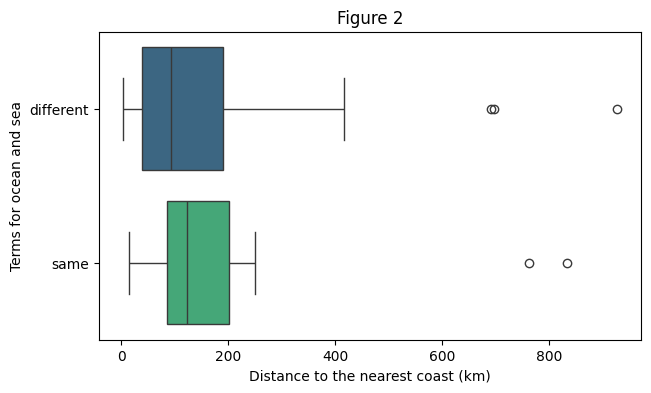

In [16]:
# Figure 2. : Boxplot of the distance to a coast depending on the colexificatation or not of the two senses
plt.figure(figsize=(7, 4)) # Setting the size of the plot
sns.boxplot(data=gdf_languages,
            x='distance_to_coast_km',
            y='Number_of_terms_bin',
            palette="viridis",
            legend=False)
plt.xlabel('Distance to the nearest coast (km)') # labelling the axes
plt.ylabel('Terms for ocean and sea')
plt.title('Figure 2')
plt.show()

In [12]:
print(gdf_languages.groupby('Number_of_terms_bin')['distance_to_coast_km'].mean())

Number_of_terms_bin
different    206.920540
same         230.677564
Name: distance_to_coast_km, dtype: float64


###3.1 Data modelling

In [13]:
# T-test of the difference of the number of terms depending on the distance to a coast
distance_coast_same = gdf_languages[gdf_languages['Number_of_terms_bin'] == 'same']['distance_to_coast_km']
distance_coast_different = gdf_languages[gdf_languages['Number_of_terms_bin'] == 'different']['distance_to_coast_km']

t_statistic, p_value = stats.ttest_ind(distance_coast_same, distance_coast_different) # Performing the test

print(f"t-stat: {t_statistic:.4f}")
print(f"p-value: {p_value:.4f}")

t-stat: 0.2427
p-value: 0.8099


###3.2 Results

Languages that don't colexify "OCEAN" and "SEA" are less far from a coast than the languages that colexify them ($\mu_1 = 206.9$, $\mu_2 = 230.6$, see **Figure 2**). This difference is not significant ($t = 0.2427$, $p = 0.8099$).

#4. Conclusion

Our result indicates that people are more likely to distinguish the sense of SEA and OCEAN when there are not far from a coast, but it is not significant. We can't validate or invalidate our prediction.

It should be noted that the number of languages that possess the two sense OCEAN and SEA is very low in our dataset.

#5. Reference

Regier T, Carstensen A, Kemp C (2016) Languages Support Efficient Communication about the Environment: Words for Snow Revisited. PLOS ONE 11(4): e0151138.